<a href="https://colab.research.google.com/github/LeeSeungwon89/Kaggle_Dacon_Practice/blob/main/Titanic_final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

In [2]:
ls -1ha kaggle.json

kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning이 발생하지 않도록 해줍니다.
!chmod 600 ~/.kaggle/kaggle.json

# 참가한 대회 리스트를 확인합니다.
!kaggle competitions list

In [4]:
!kaggle competitions download -c titanic

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 1.99MB/s]


In [5]:
!ls

kaggle.json  sample_data  titanic.zip


In [6]:
!unzip titanic.zip

Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# **1. 최종 성능 개선 시도**

이번엔 베이스라인 모델링에서 수행한 피처 엔지니어링에서 개선할 점이 있는지 모색해 보겠습니다.

# **2. 새로운 피처 엔지니어링**

In [7]:
import numpy as np
import pandas as pd

pd.set_option('display.max_column', 50)
pd.set_option('display.max_rows', 50)

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('gender_submission.csv')

# 피처 엔지니어링을 위해 훈련 및 테스트 데이터를 결합합니다.
all_data = pd.concat([train, test], ignore_index=True)
all_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [8]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


피처 요약표를 출력하겠습니다.

In [9]:
def feature_table(df):
    # 피처 이름과 타입을 출력합니다.     
    feature_description = pd.DataFrame(df.dtypes, columns=['type'])
    feature_description = feature_description.reset_index()
    feature_description = feature_description.rename(columns={'index': 'feature'})
    # 결측치 개수를 산출합니다.
    feature_description['null count'] = df.isnull().sum().values
    # 고윳값 개수를 산출합니다.
    feature_description['eigenvalue count'] = df.nunique().values
    
    # 데이터 크기를 출력합니다.    
    print(df.shape)
    
    return feature_description

In [10]:
feature_table(all_data)

(1309, 12)


,feature,type,null count,eigenvalue count
0,PassengerId,int64,0,1309
1,Survived,float64,418,2
2,Pclass,int64,0,3
3,Name,object,0,1307
4,Sex,object,0,2
5,Age,float64,263,98
6,SibSp,int64,0,7
7,Parch,int64,0,8
8,Ticket,object,0,929
9,Fare,float64,1,281


## **2.1. 결측치 처리**

### **2.1.1. Age**

'Age' 피처의 결측치를 처리하겠습니다. 먼저 'Age' 피처의 값 분포를 확인하겠습니다.

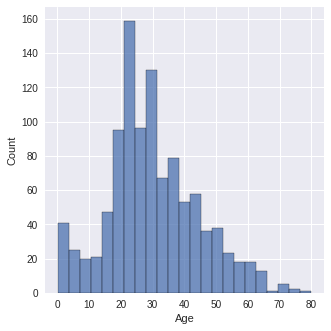

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

mpl.rc('font', size=20)
plt.style.use('seaborn')

sns.displot(x='Age', data=all_data)

베이스라인 모델링에서는 'Pclass' 피처별 'Age' 피처의 평균값으로 결측치를 채웠습니다. 이번엔 다른 피처별로 평균값을 채워볼 것입니다. 일단 다른 피처부터 처리하고 **2.7. 추가 작업** 파트에서 처리하겠습니다.

### **2.1.2. Fare**

'Fare' 피처의 결측치를 처리하겠습니다. 'Fare' 피처는 결측치가 1개이므로 평균값으로 채울 예정입니다. 'Pclass' 피처별 'Fare' 피처의 평균값을 채우는 편이 옳다고 판단합니다.

In [12]:
pclass_fare_mean = all_data[['Pclass', 'Fare']].groupby('Pclass').mean().reset_index()
pclass_fare_mean.columns = ['Pclass', 'Fare_mean']
pclass_fare_mean

,Pclass,Fare_mean
0,1,87.508992
1,2,21.179196
2,3,13.302889


이 데이터프레임을 원본 데이터에 병합하겠습니다.

In [13]:
all_data = pd.merge(all_data, pclass_fare_mean, on='Pclass', how='left')

병합된 평균 피처를 결측치에 채우고 삭제하겠습니다.

In [14]:
all_data.loc[all_data['Fare'].isnull(), 'Fare'] = all_data['Fare_mean']
all_data = all_data.drop('Fare_mean', axis=1)

티켓요금 분포를 확인하겠습니다.

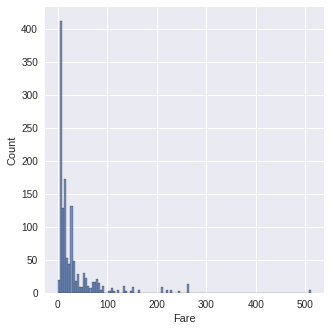

In [15]:
sns.displot(x='Fare', data=all_data)

### **2.1.3. Cabin**

EDA에서 'Cabin' 피처는 사용하기 부적절하여 제거하는 편이 낫다는 판단을 내렸습니다. 제거하겠습니다.

In [16]:
all_data = all_data.drop('Cabin', axis=1)

### **2.1.4. Embarked**

마지막으로 'Embarked' 피처는 명목형 피처이므로 최빈값으로 대체해 보겠습니다.

In [17]:
all_data['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [18]:
# all_data['Embarked'] = all_data['Embarked'].fillna('S')
all_data.loc[all_data['Embarked'].isnull(), 'Embarked'] = 'S'

## **2.2. 파생 피처 생성**

### **2.2.1. Appellation**

이름에서 호칭을 분리하여 새 피처를 생성하겠습니다. 먼저 고윳값을 확인하겠습니다.

In [19]:
all_data['Name'].unique()[:10]

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry', 'Moran, Mr. James',
       'McCarthy, Mr. Timothy J', 'Palsson, Master. Gosta Leonard',
       'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)',
       'Nasser, Mrs. Nicholas (Adele Achem)'], dtype=object)

In [20]:
print(all_data['Name'].str.extract('([A-Za-z]*)\.')[0].unique())

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer' 'Dona']


EDA에서 발견하지 못한 레이블 'Dona'가 테스트 세트에 존재하는 것으로 확인됩니다. 'Dona'의 의미는 아래와 같습니다.

- Dona: 포르투갈의 귀부인 -> 'Mrs'

호칭을 분리하여 새 피처를 생성하겠습니다.

In [21]:
all_data['Appellation'] = all_data['Name'].str.extract('([A-Za-z]*)\.')

In [22]:
pd.crosstab(all_data['Sex'], all_data['Appellation'], margins=True)

Appellation,Capt,Col,Countess,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,All
Sex,,,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0,466
male,1,4,0,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1,843
All,1,4,1,1,1,8,1,1,2,61,260,2,1,757,197,2,8,1,1309


'Dona' 레이블은 여성 1명입니다. 'Mrs'로 치환하기에 적합합니다. 모든 레이블을 치환하겠습니다. 

In [23]:
original_label = ['Capt', 'Col', 'Countess', 'Don', 'Dona', 'Dr', 'Jonkheer', 'Lady', 'Major', 'Mlle', 'Mme', 'Ms', 'Rev', 'Sir']
replace_label = ['Mr', 'Mr', 'Mrs', 'Mr', 'Mrs', 'Mr', 'Mr', 'Mrs', 'Mr', 'Miss', 'Mrs', 'Miss', 'Mr', 'Mr']
all_data['Appellation'].replace(original_label, replace_label, inplace=True)

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

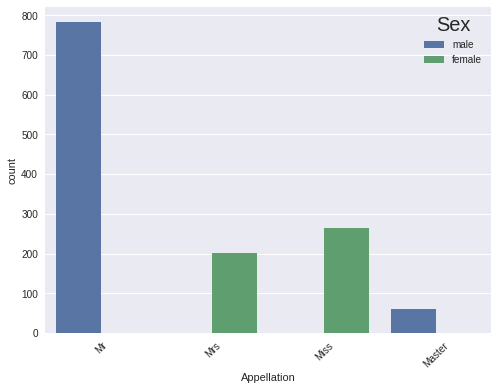

In [24]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Appellation', hue='Sex', data=all_data)
plt.xticks(rotation=45)

In [25]:
all_data.groupby('Appellation').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Appellation,,,,,,,
Master,658.852459,0.575000,2.655738,5.482642,2.049180,1.377049,36.008195
Miss,617.928030,0.702703,2.337121,21.824366,0.655303,0.496212,42.566747
Mr,658.936143,0.161710,2.348659,32.811056,0.286079,0.159642,25.370250
Mrs,687.189055,0.796875,1.920398,36.971264,0.651741,0.815920,51.068470


### **2.2.2. um_sibsp_parch**

총 가족수를 나타내는 피처를 생성하겠습니다. 베이스라인 모델링과 달리 1을 더하여 1명을 가리키는 값을 만들겠습니다.

In [26]:
all_data['Sum_sibsp_parch'] = all_data['SibSp'] + all_data['Parch'] + 1

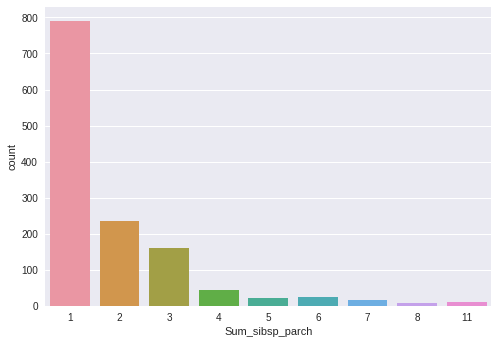

In [27]:
sns.countplot(x='Sum_sibsp_parch', data=all_data)

In [28]:
all_data.groupby('Sum_sibsp_parch').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Sum_sibsp_parch,,,,,,,
1,663.743038,0.303538,2.394937,31.511864,0.000000,0.000000,21.749475
2,626.148936,0.552795,1.893617,32.726942,0.778723,0.221277,51.228106
3,687.635220,0.578431,2.226415,26.534097,0.893082,1.106918,41.566062
4,708.139535,0.724138,2.116279,19.423333,1.302326,1.697674,51.186047
5,594.272727,0.200000,2.500000,23.764706,2.000000,2.000000,80.067432
6,466.240000,0.136364,2.480000,20.120000,2.800000,2.200000,87.081000
7,547.375000,0.333333,3.000000,17.375000,3.250000,2.750000,28.396094
8,553.250000,0.000000,3.000000,18.000000,4.000000,3.000000,46.900000
11,745.000000,0.000000,3.000000,14.500000,6.727273,3.272727,69.550000


## **2.4. 피처 스케일링**

### **2.4.1. Fare**

'Fare' 피처는 왜도가 큽니다. 넘파이의 `log()` 메서드를 적용하여 로그 변환을 수행하겠습니다. 언더 플로우를 방지하기 위해 `log1p()` 메서드를 사용하는 편이 좋지만 일단 그대로 적용해 보겠습니다.

In [29]:
all_data['Fare'] = all_data['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

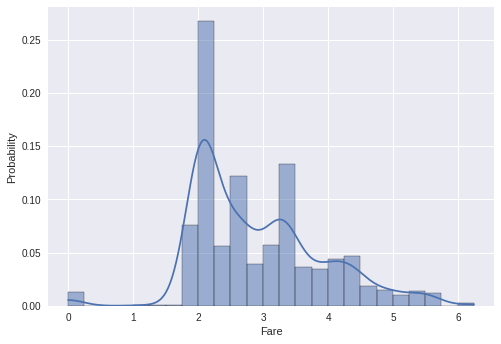

In [30]:
sns.histplot(x=all_data['Fare'], kde=True, stat='probability')

## **2.5. 불필요한 피처 처리**

분석에 불필요한 피처는 'PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket'입니다. 제거하겠습니다.

In [31]:
drop_feature_list = ['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket']
all_data = all_data.drop(drop_feature_list, axis=1)

In [32]:
all_data.head(3)

,Survived,Pclass,Sex,Age,Fare,Embarked,Appellation,Sum_sibsp_parch
0,0.0,3,male,22.0,1.981001,S,Mr,2
1,1.0,1,female,38.0,4.266662,C,Mrs,2
2,1.0,3,female,26.0,2.070022,S,Miss,1


## **2.7. 추가 작업**

베이스라인 모델링에서 수행하지 않은 방법으로 추가 피처 엔지니어링을 수행하겠습니다.

### **2.7.1. Age**

#### **2.7.1.1. 결측치 처리**

이번엔 'Appellation'별 'Age'의 평균값으로 결측치를 채워 보겠습니다.

In [33]:
appellation_age_mean = all_data[['Appellation', 'Age']].groupby('Appellation').mean().reset_index()
appellation_age_mean.columns = ['Appellation', 'Age_mean']
appellation_age_mean

,Appellation,Age_mean
0,Master,5.482642
1,Miss,21.824366
2,Mr,32.811056
3,Mrs,36.971264


In [34]:
all_data = pd.merge(all_data, appellation_age_mean, on='Appellation', how='left')

In [35]:
all_data.loc[all_data['Age'].isnull(), 'Age'] = all_data['Age_mean']
all_data = all_data.drop('Age_mean', axis=1)

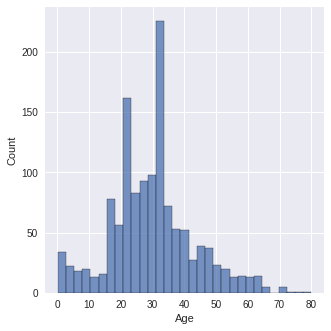

In [36]:
sns.displot(x='Age', data=all_data)

In [37]:
all_data.head(3)

,Survived,Pclass,Sex,Age,Fare,Embarked,Appellation,Sum_sibsp_parch
0,0.0,3,male,22.0,1.981001,S,Mr,2
1,1.0,1,female,38.0,4.266662,C,Mrs,2
2,1.0,3,female,26.0,2.070022,S,Miss,1


#### **2.7.1.2. 피처 범주화**

'Age' 피처는 범위가 매우 넓은 편입니다. 범위를 몇 개의 범주로 나누겠습니다. 기준은 임의로 지정하겠습니다.

In [38]:
def age_category(age):
    cat = ''
    if age <= 5:
        cat = 'Baby'
    elif age <= 12:
        cat = 'Child'
    elif age <= 19:
        cat = 'Teen'
    elif age <= 29:
        cat = 'Young'
    elif age <= 44:
        cat = 'Adult'
    elif age <= 65:
        cat = 'Middle Adult'
    else:
        cat = 'old'

    return cat

In [39]:
all_data['Age'] = all_data['Age'].map(lambda x: age_category(x))

In [40]:
all_data['Age'].value_counts()

Adult           505
Young           395
Middle Adult    166
Teen            131
Baby             56
Child            46
old              10
Name: Age, dtype: int64

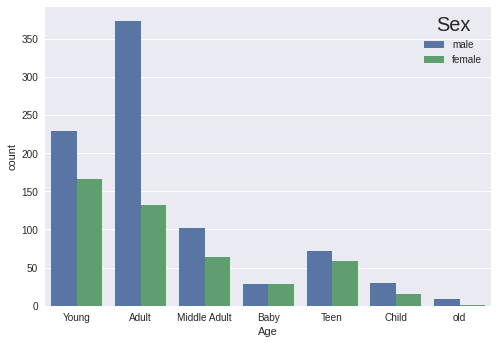

In [41]:
sns.countplot(x='Age', hue='Sex', data=all_data)

### **2.7.2. Alone**

홀로 승선한 탑승객을 나타내는 피처를 생성해 보겠습니다.

In [42]:
all_data.loc[all_data['Sum_sibsp_parch']==1, 'Alone'] = 1 # 홀로 승선했다면 1입니다.
all_data['Alone'].fillna(0, inplace=True) # 홀로 승선하지 않았다면 0입니다.
all_data['Alone'] = all_data['Alone'].astype('int') # `float` 타입이므로 `int` 타입으로 변환합니다.

In [43]:
all_data.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Appellation,Sum_sibsp_parch,Alone
0,0.0,3,male,Young,1.981001,S,Mr,2,0
1,1.0,1,female,Adult,4.266662,C,Mrs,2,0
2,1.0,3,female,Young,2.070022,S,Miss,1,1
3,1.0,1,female,Adult,3.972177,S,Mrs,2,0
4,0.0,3,male,Adult,2.085672,S,Mr,1,1


## **2.8. 카테고리 피처 처리**

### **2.8.1. 원-핫 인코딩**

'Sex', 'Age', 'Embarked', 'Appellation' 피처는 명목형 피처이므로 레이블 인코딩이나 원-핫 인코딩을 적용할 필요가 있습니다. `OneHotEncoder()` 클래스는 명목형 피처와 순위형 피처 모두 원-핫 인코딩을 수행하고, 판다스의 `get_dummies()` 메서드는 명목형 피처만 원-핫 인코딩을 수행합니다. 일단 `get_dummies()` 메서드를 적용하여 XGBoost와 LightGBM 모델 생성에 초점을 맞추겠습니다. LogisticRegression 모델 생성까지 고려하려면 모든 피처에 원-핫 인코딩을 수행하는 편이 좋습니다.

In [44]:
all_data_ohe = pd.get_dummies(all_data)
all_data_ohe.head(3)

,Survived,Pclass,Fare,Sum_sibsp_parch,Alone,Sex_female,Sex_male,Age_Adult,Age_Baby,Age_Child,Age_Middle Adult,Age_Teen,Age_Young,Age_old,Embarked_C,Embarked_Q,Embarked_S,Appellation_Master,Appellation_Miss,Appellation_Mr,Appellation_Mrs
0,0.0,3,1.981001,2,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0
1,1.0,1,4.266662,2,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
2,1.0,3,2.070022,1,1,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0


## **2.9. 피처 상관관계 확인**

피처간 상관관계를 살펴 보겠습니다.

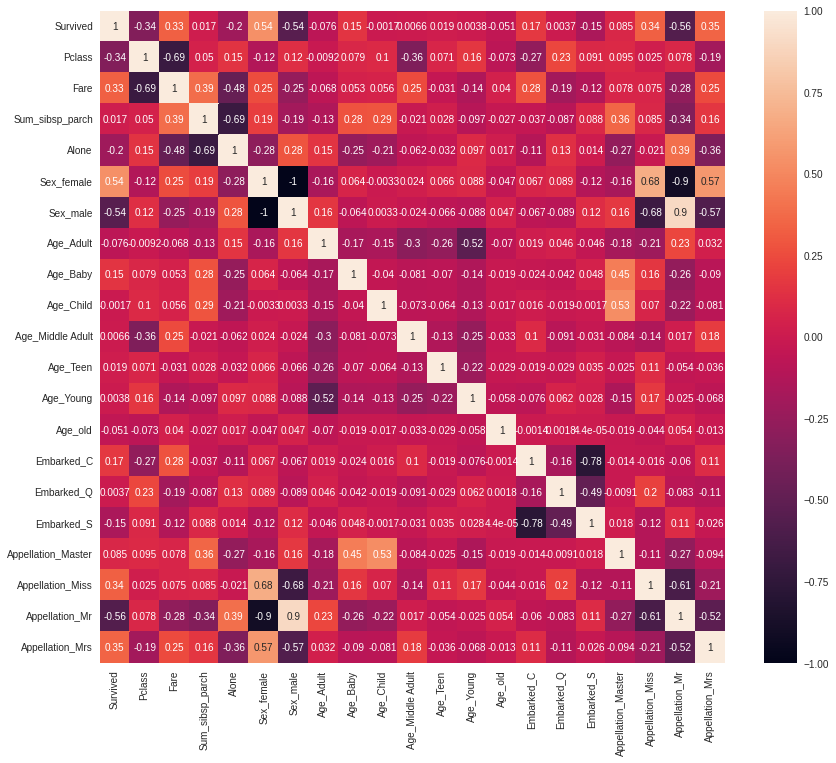

In [45]:
all_data_ohe_corr = all_data_ohe.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(all_data_ohe_corr, annot=True, annot_kws={"size": 10})

'Sex_female' 피처의 경우 'Sex_male'과 'Appellation_Mr' 피처와 매우 강한 상관관계를 나타냅니다. 'Sex_female' 피처를 제거하여 다중공선성을 제거하겠습니다. 이외 다른 피처도 강한 상관관계를 나타내는 피처가 있으나 0.8 미만이므로 일단 제거하지 않고 그대로 사용하겠습니다. 'Sex_male'과 'Appellation_Mr' 피처 간 상관계수도 높게 나타납니다. 일견 'Sex_female'처럼 'Sex_male' 피처도 삭제하는 편이 옳은 결정일 수 있지만 기실 그대로 두어도 무방합니다. 이유인즉슨 결정트리 기반의 앙상블 모델은 다중공선성을 고려할 필요가 없고 이 모델에 해당하는 XGBoost나 LightGBM 모델의 성능이 더 좋을 것으로 예상해 볼 수 있으므로 사실상 'Sex_female' 피처 또한 굳이 삭제해도 성능에 큰 영향을 주지 않습니다.

In [46]:
all_data_ohe.drop(['Sex_female'], axis=1, inplace=True)

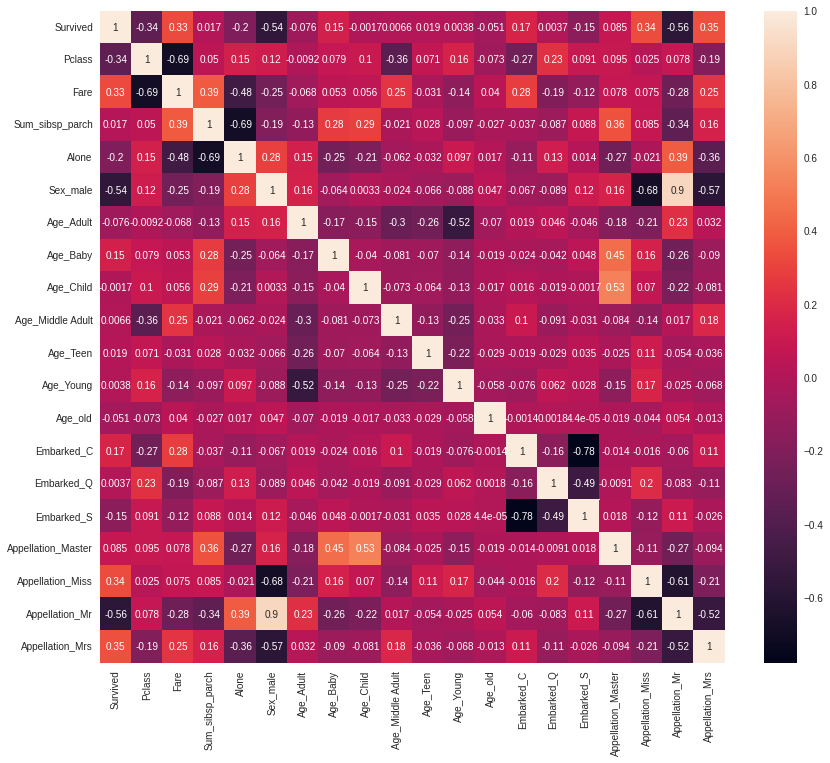

In [47]:
all_data_ohe_corr = all_data_ohe.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(all_data_ohe_corr, annot=True, annot_kws={"size": 10})

# **3. 모델링**

## **3.1. 모델 생성 및 성능 검증**

데이터를 준비하겠습니다.

In [52]:
from sklearn.model_selection import train_test_split

# 훈련 세트 개수를 지정합니다.
train_num = len(train)

X_train_df = all_data_ohe[:train_num].drop('Survived', axis=1) # 훈련 세트를 지정합니다.
X_test_df = all_data_ohe[train_num:].drop('Survived', axis=1) # 테스트 세트를 지정합니다.
y_train_df = train['Survived'] # 타깃값을 지정합니다.

### **3.1.1. LogisticRegression**

#### **3.1.1.1. 하이퍼파라미터 튜닝**

하이퍼파라미터 튜닝에 사용할 패키지는 `optuna`입니다.

In [53]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 7.5 MB/s 
     |████████████████████████████████| 210 kB 52.1 MB/s 
     |████████████████████████████████| 81 kB 10.0 MB/s 
     |████████████████████████████████| 78 kB 5.7 MB/s 
     |████████████████████████████████| 50 kB 6.3 MB/s 
     |████████████████████████████████| 147 kB 66.0 MB/s 
     |████████████████████████████████| 112 kB 58.4 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=104734237d349ae3d4c1d76d73cf538e72555fdfc9ec3a4d92a2eeb957ec286b
  Stored in directory: /root/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 5.1.0
    Uninstalling importlib-metadata-5.1.0:
      Successfully uninstalled importlib-metadata-5.1.0


In [54]:
from sklearn.linear_model import LogisticRegression
import optuna
from sklearn.model_selection import cross_val_score

def objective_LogReg(trial, X_train, y_train):
    params = {
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'C': trial.suggest_float('C', 1e-4, 100),
        'max_iter': trial.suggest_int('max_iter', 5000, 10000),
        "solver": trial.suggest_categorical('solver', ['liblinear', 'saga']),
        'random_state': 11
    }
    model = LogisticRegression(**params)
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=5).mean()

    return scores

In [55]:
from optuna.samplers import TPESampler

# 시도 과정을 출력하지 않는 코드입니다.
optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(sampler=TPESampler(), direction='maximize')
study.optimize(lambda trial: objective_LogReg(trial, X_train_df, y_train_df), n_trials=50,
               show_progress_bar=True)

print(f'Best trial score: {study.best_trial.value}')
print(f'Best params: {study.best_trial.params}')

/usr/local/lib/python3.8/dist-packages/optuna/progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial score: 0.8204569706860836
Best params: {'penalty': 'l1', 'C': 62.21915046881677, 'max_iter': 6216, 'solver': 'saga'}


#### **3.1.1.2. 모델 훈련**

In [56]:
params = study.best_trial.params
logistic_reg_model = LogisticRegression(**params)
logistic_reg_model.fit(X_train_df, y_train_df)
prediction_logistic_reg = logistic_reg_model.predict(X_test_df)

In [57]:
submission['Survived'] = prediction_logistic_reg
# submission.to_csv('Titanic_submission_21.csv', index=False)

### **3.1.2. XGBoost**

#### **3.1.2.1. 하이퍼파라미터 튜닝**

In [58]:
from xgboost import XGBClassifier
import optuna
from sklearn.model_selection import cross_val_score

def objective_XGB(trial, X_train, y_train):
    params = {
        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 100),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 100),
        'gamma': trial.suggest_float('gamma', 0, 100),
        'random_state': 11
    }
    model = XGBClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=5).mean()

    return scores

In [59]:
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(lambda trial: objective_XGB(trial, X_train_df, y_train_df), n_trials=500,
               show_progress_bar=True)

print(f'Best trial score: {study.best_trial.value}')
print(f'Best params: {study.best_trial.params}')

/usr/local/lib/python3.8/dist-packages/optuna/progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/500 [00:00<?, ?it/s]

Best trial score: 0.8338710689849979
Best params: {'booster': 'dart', 'learning_rate': 0.029131083903045907, 'n_estimators': 366, 'max_depth': 10, 'subsample': 0.9694102838726134, 'colsample_bytree': 0.8879379350054342, 'reg_alpha': 17.40649478104057, 'reg_lambda': 31.93745055769702, 'gamma': 0.46154028648300427}


#### **3.1.2.2. 모델 훈련**

In [60]:
params = study.best_trial.params
xgb_clf_model = XGBClassifier(**params)
xgb_clf_model.fit(X_train_df, y_train_df)
prediction_xgb_clf = xgb_clf_model.predict(X_test_df)

In [67]:
submission['Survived'] = prediction_xgb_clf
# submission.to_csv('Titanic_submission_25.csv', index=False)

### **3.1.3. LightGBM**

#### **3.1.3.1. 하이퍼파라미터 튜닝**

In [62]:
from lightgbm import LGBMClassifier
import optuna
from sklearn.model_selection import cross_val_score

def objective_LGBM(trial, X_train, y_train):
    params = {
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'num_leaves': trial.suggest_int('num_leaves', 31, 100),
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 100),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 500),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10),
        'random_state': 11
    }
    model = LGBMClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=5).mean()

    return scores

In [63]:
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(lambda trial: objective_LGBM(trial, X_train_df, y_train_df), n_trials=500,
               show_progress_bar=True)

print(f'Best trial score: {study.best_trial.value}')
print(f'Best params: {study.best_trial.params}')

/usr/local/lib/python3.8/dist-packages/optuna/progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/500 [00:00<?, ?it/s]

Best trial score: 0.8507626639884502
Best params: {'boosting_type': 'gbdt', 'learning_rate': 0.09761432246536429, 'n_estimators': 514, 'num_leaves': 66, 'max_depth': 21, 'subsample': 0.8366186340847198, 'colsample_bytree': 0.6160518808060583, 'reg_alpha': 0.06768718833292858, 'reg_lambda': 7.253990763050593, 'min_child_samples': 28, 'min_child_weight': 9.554603964618952}


#### **3.1.3.2. 모델 훈련**

In [64]:
params = study.best_trial.params
lgbm_clf_model = LGBMClassifier(**params)
lgbm_clf_model.fit(X_train_df, y_train_df)
prediction_lgbm_clf = lgbm_clf_model.predict(X_test_df)

In [68]:
submission['Survived'] = prediction_lgbm_clf
# submission.to_csv('Titanic_submission_26.csv', index=False)

## **3.2. 앙상블**

In [66]:
prediction_ensemble = (prediction_xgb_clf * 0.5) + (prediction_lgbm_clf * 0.5)
prediction_ensemble_to_int = (prediction_ensemble > 0.5).astype(int) # 0.5 이상을 생존으로 간주합니다.
submission['Survived'] = prediction_ensemble_to_int
# submission.to_csv('Titanic_submission_24.csv', index=False)

# **4. 결론**

위 모든 모델을 제출한 결과, 가장 높은 퍼블릭 스코어는 XGBoost 모델의 0.78468입니다. 앙상블의 경우 오히려 점수가 더 낮았습니다. 물론 더욱 다양한 피처 엔지니어링을 수행하여 스코어를 향상시킬 여지는 충분합니다. 두 피처를 곱하여 파생 피처를 생성하거나 특정 피처들에 다양한 피처 스케일링 방안을 적용해 볼 수 있습니다. 데이터 누수가 일어나지 않도록 과적합 정도를 세심하게 제어해 볼 수도 있습니다. 추후 기회가 되면 더 시도해 보도록 하겠습니다.